# **3-Level Classfication**

In [1]:
subject_list = [1, 3, 4, 5, 7]
EEG_channel_list = [3]
subject_test = '2'
seed = 42

## **1. Import Libraries**

In [2]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graph
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data

from imblearn.over_sampling import SMOTE


from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

## **2. Function**

In [3]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    channelList_pre = data['channelList'][0]
    channelList = []
    for i in range(len(channelList_pre)):
        channelList.append(channelList_pre[i][0])
    
    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min, channelList

In [4]:
def ECG_dataframe(subject, ECG_features_allcases):
    ECG_features_py = []
    
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)

    # Convert scalar values to DataFrame
    ECG_features_df = pd.DataFrame(ECG_features_py)
    
    return ECG_features_df

In [5]:
def EEG_dataframe_list(subject, EEG_features_allcases, channelList_allcases):
    
    EEG_features_df_list = []

    numEEGchannels = EEG_features_allcases[subject].shape[1]
    numEEGepochs = EEG_features_allcases[subject].shape[0]
    EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

    # Assuming struct_array is of shape (139, 12), iterate through each struct
    for channel in range(numEEGchannels):  # for j in range(12)
        channelfeatures = []
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)
        
        channelfeatures_df = pd.DataFrame(channelfeatures)
        EEG_features_df_list.append(channelfeatures_df)

    if numEEGchannels != 12:
        channelSubject = channelList_allcases[subject]
        channelAll = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']
        # for i in range(len(channelAll)):
        #     if channelSubject[i] != channelAll[i]:
        #         EEG_features_df_list.insert(i, [])
        n = 0
        for i in range(len(channelAll)):
            if channelSubject[i-n] != channelAll[i]:
                EEG_features_df_list.insert(i, [])
                n += 1
        
    return EEG_features_df_list

In [6]:
def ord_dataframe(subject, ord_60min_allcases):
    
    # 1) ord_60min -> ord_epoch
    ord_epoch = []

    for i in range(len(ord_60min_allcases[subject]) - 1):
        # Append the current ORD value
        ord_epoch.append(ord_60min_allcases[subject].iloc[i, 3])
        
        # Calculate and append the mean of the current and next ORD values
        mean_ord = np.mean([ord_60min_allcases[subject].iloc[i, 3], ord_60min_allcases[subject].iloc[i + 1, 3]])
        ord_epoch.append(mean_ord)

    # Append the last ORD value since it won't have a subsequent value to average with
    ord_epoch.append(ord_60min_allcases[subject].iloc[-1, 3])

    # Convert the list to a DataFrame and set the column title as 'ord score'
    ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

    #######################################

    # 2) Simplify to 3 classes
    ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))
    # ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2)))


    # Mapping from 'ORD class' to 'class name'
    class_name_mapping = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }

    # Add 'class name' column by mapping 'ORD class' to names
    ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

    return ord_epoch
    

In [7]:
def combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch):
    # EEG_features_df (df 139x7): row 10-128, column 1-6
    # ECG_features_df (df 139x7): row 10-128, column 1-6
    # ord_epoch (df 119x3): all row, column 1-2

    # 1) Select the specified rows and columns from each DataFrame
    # EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    # EEG_features_selected = EEG_features_df.loc[10:129, EEG_features_df.columns != 'Epoch']
    ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
    ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

    if not EEG_features_df.empty:
        EEG_features_selected = EEG_features_df.loc[10:129, ~EEG_features_df.columns.str.startswith('Epoch')]



    # 2) Combine these features into a new DataFrame
    # Concatenate EEG and ECG features along the columns
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    EEG_features_selected.reset_index(drop=True), 
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)
    else:
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)        
    # combined_data = combined_data.dropna()

    # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
    return combined_data

In [8]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

    # Package the metrics into a dictionary
    metrics = {
        'class_accuracies': class_accuracies,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
    }

    return metrics

In [9]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

In [10]:
def perform_PCA(X_train, X_test, n_components, viz_idx):

    pca = PCA()
    pca_scaler = StandardScaler()

    X_train_pca_components = pca.fit_transform(X_train)
    X_train_selected_components = []
    for n in range(0, n_components):
        component = X_train_pca_components[:, n]
        X_train_selected_components.append(component)
    X_train_selected_components = np.array(X_train_selected_components)
    X_train_pca = pca_scaler.fit_transform(X_train_selected_components.T)


    X_test_pca_components = pca.fit_transform(X_test)
    X_test_selected_components = []
    for n in range(0, n_components):
        component = X_test_pca_components[:, n]
        X_test_selected_components.append(component)
    X_test_selected_components = np.array(X_test_selected_components)
    X_test_pca = pca_scaler.fit_transform(X_test_selected_components.T)

    def visualize_comps(viz_idx):
        loading_scores = pd.Series(pca.components_[viz_idx], index=features)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        top_10_features = sorted_loading_scores[0:10].index.values
        print(f'Visualizing PC {viz_idx}: \n' 
              f'{loading_scores[top_10_features]}')

        per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.xticks()
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Components')
        plt.title('Scree Plot')
        plt.tight_layout()
        plt.show()

    visualize_comps(viz_idx)
    return(X_train_pca, X_test_pca)

# X_train_pca, X_test_pca = perform_PCA(X_train, X_test, n_components = 5, viz_idx = 1)

In [11]:
def accuracy_record(dataframe, model, subject_train, subject_test, EEG_channel_train, X, X_test_scaled, y_test):
    # Assuming classwise_accuracy is defined elsewhere and returns a dictionary with the metrics
    metrics = classwise_accuracy(model, X_test_scaled, y_test)

    if isinstance(X, str) and X == 'pca':
        input_features = 'PCA'
    else:
        input_features = ', '.join(X.columns)

    # Prepare the record to be appended
    record = {
        # 'model': type(model).__name__,  # Get the class name of the model
        'model': str(model),
        'subject_train': subject_train,
        'subject_test': subject_test,
        'channel' : EEG_channel_train,
        'input_features': input_features,  # Column names as a string
        'num_features': model.n_features_in_,
        'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
        'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
        'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
        'micro_f1': metrics['micro_f1'],
        'weighted_f1': metrics['weighted_f1'],
        'macro_f1': metrics['macro_f1'],
    }

    # Append the record to the DataFrame
    record_df = pd.DataFrame.from_records([record])
    dataframe = pd.concat([dataframe, record_df], ignore_index=True)
    
    return dataframe


In [12]:
accuracy_df = pd.DataFrame()

In [13]:
# def accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test):
#     # store the accuracy in the dataframe

#     # column: model, subject_train, subject_test, input_features, classwise accuracy (3 columns for 3 classes), F1 scores (3 columns for micro, weighted, macro)
#     # append the row with these columns to the dataframe

#     # input_features = X.columns

#     #############################################
#     # Get the metrics from classwise_accuracy
#     metrics = classwise_accuracy(model, X_test_scaled, y_test)

#     # Prepare the record to be appended
#     record = {
#         'model': type(model).__name__,  # Get the class name of the model
#         'subject_train': subject_train,
#         'subject_test': subject_test,
#         'input_features': ', '.join(X.columns),  # Column names as a string
#         'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
#         'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
#         'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
#         'micro_f1': metrics['micro_f1'],
#         'weighted_f1': metrics['weighted_f1'],
#         'macro_f1': metrics['macro_f1'],
#     }

#     # Append the record to the DataFrame
#     # dataframe = dataframe.append(record, ignore_index=True)
#     dataframe = pd.concat([dataframe, record], axis=1)
#     # class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])

    
#     return dataframe

    

## **3. Import the Data**

##### 2.1 Load the .mat file (input) and .csv file (output)

In [14]:
# subject_list = []

# while True:
#     subject = input('subject: ')
#     if subject == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             subject_number = int(subject)
#             subject_list.append(subject_number)
            
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

print("Subjects entered:", subject_list)

subject_train = ''.join(str(x) for x in subject_list)
print(subject_train)


Subjects entered: [1, 3, 4, 5, 7]
13457


In [15]:
for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    print(subject)


1
3
4
5
7


In [16]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []
channelList_allcases = []

for subject in subject_list:
    ECG_features, EEG_features, ord_60min, channelList = load_subject_data(subject)
    EEG_features_allcases.append(EEG_features)
    ECG_features_allcases.append(ECG_features)
    ord_60min_allcases.append(ord_60min)
    channelList_allcases.append(channelList)



In [17]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [18]:
n = 0
for subject_order in range(len(subject_list)): 
    print(subject_order)

0
1
2
3
4


In [19]:
ord_subject1 = ord_dataframe(1, ord_60min_allcases)
ord_subject1['class name'].value_counts()

class name
Moderately Drowsy    65
Alert                42
Extremely Drowsy      4
Name: count, dtype: int64

In [20]:
# EEG_channel_list = []

# while True:
#     channel = input('training channel: ')
#     if channel == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             channel_number = int(channel)
#             EEG_channel_list.append(channel_number)
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

# print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


3


In [21]:
# # EEG_channel = 3
# EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases) # EEG_features_df_list
# EEG_features_df = pd.DataFrame()
# for EEG_channel in EEG_channel_list:
#     EEG_features_append = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
#     EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
# EEG_features_df

In [22]:
# EEG_features_df.iloc[10:15,:]

In [23]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [24]:
# subject = int(input('subject: '))
# initial_kss[subject-1]

In [25]:
# EEG_channel = int(input('EEG Channel: '))
# EEG_channel = 3

combined_data_allcases = pd.DataFrame()

for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    ECG_features_df = ECG_dataframe(subject_order, ECG_features_allcases) # ECG_features_df
    
    EEG_features_df_list = EEG_dataframe_list(subject_order, EEG_features_allcases, channelList_allcases) # EEG_features_df_list
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
    EEG_features_df = pd.DataFrame()

    for EEG_channel in EEG_channel_list:
        EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from Channel 1
        EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
        EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
    
    ord_epoch = ord_dataframe(subject_order, ord_60min_allcases)
    
    print(ord_epoch['class name'].value_counts())

    combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
    
    combined_data.insert(1, 'Initial_KSS', initial_kss[subject-1])

    # display(EEG_features_df[10:15])
    # display(combined_data)
    combined_data_allcases = pd.concat([combined_data_allcases, combined_data], axis=0)

combined_data_allcases = combined_data_allcases.dropna()

display(combined_data_allcases)

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64
class name
Moderately Drowsy    65
Alert                42
Extremely Drowsy      4
Name: count, dtype: int64
class name
Alert                70
Moderately Drowsy    43
Name: count, dtype: int64
class name
Alert                99
Moderately Drowsy     7
Name: count, dtype: int64
class name
Moderately Drowsy    74
Alert                36
Extremely Drowsy      9
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,7,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,7,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,7,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,7,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,5,0.767012,0.103791,0.076956,0.053555,1.436954,3.374992,1.022807,0.569930,0.478651,1.190703,54.352543,45.647457,2.0,Moderately Drowsy
115,58.5,5,0.741962,0.114125,0.084110,0.057280,1.468405,3.460820,0.440881,1.490997,0.202128,7.376498,88.061837,11.938163,2.0,Moderately Drowsy
116,59.0,5,0.751298,0.122404,0.064071,0.061107,1.048512,3.051622,0.343341,1.612073,0.170341,9.463822,90.443263,9.556737,2.0,Moderately Drowsy
117,59.5,5,0.757090,0.109241,0.063436,0.067877,0.934574,2.543979,0.918173,1.006392,0.177527,5.668960,85.005159,14.994841,2.0,Moderately Drowsy


In [26]:
len(EEG_features_df_list)

12

In [27]:
for i in range(len(subject_list)):
    EEG_features_df_list_test = EEG_dataframe_list(1, EEG_features_allcases, channelList_allcases)
    print(len(EEG_features_df_list_test))

12
12
12
12
12


In [28]:
for i in range(len(subject_list)):
    q = EEG_features_allcases[i].shape[1]
    print(q)

12
11
11
12
12


## **4. Data Preparation**

In [29]:
combined_data_allcases.head()

,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,7,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,7,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,7,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,7,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert


In [30]:
combined_data_allcases.columns

Index(['Epoch_minute', 'Initial_KSS', 'DeltaRelative_3', 'ThetaRelative_3',
       'AlphaRelative_3', 'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3',
       'VLF', 'LF', 'HF', 'LFHF', 'pLF', 'pHF', 'ORD class', 'class name'],
      dtype='object')

In [31]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data_allcases.iloc[:, 0:13].copy()
# X = combined_data_allcases.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()
# X_new = combined_data_allcases['Epoch_minute', 'DeltaRelative','ThetaRelative','AlphaRelative','BetaRelative','AlphaBetaRatio','TA_BRatio','VLF','LF','HF','LFHF','pLF','pHF'].copy()

excluded_columns = ['Initial_KSS', 'VLF', 'LF', 'HF', 'ORD class', 'class name']
X = combined_data_allcases.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(565, 10)


,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,2.337852,70.040617,29.959383
1,1.5,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,2.900641,74.363187,25.636813
2,2.0,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,5.113295,83.642210,16.357790
3,2.5,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,6.655165,86.936924,13.063076
4,3.0,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,3.919928,79.674498,20.325502


In [32]:
X.columns

Index(['Epoch_minute', 'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'LFHF', 'pLF',
       'pHF'],
      dtype='object')

In [33]:
# OUTPUT: ORD class
y = combined_data_allcases['ORD class'].copy()
print(y.shape)
y.head()

(565,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [34]:
# Specify seed

seed = 42

- **Split #1**

In [35]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)


In [36]:
# Count class labels in training data
class_counts_train = y_train.value_counts()

# Count class labels in testing data
class_counts_test = y_test.value_counts()

# Add 'Total' row for training and testing sets
total_train = class_counts_train.sum()
total_test = class_counts_test.sum()
class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# Add 'Total' column for class-wise sum
class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# Print the DataFrame
print(class_counts_df)

           count  count  Total
ORD class                     
1.0          234     50    284
2.0          182     42    224
3.0           36     21     57
Total        452    113    565


- **Split #2**

In [37]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
#   # Sample data for training and testing sets (modify sample size if needed)
#   train_data = class_data.sample(int(len(class_data) * train_size))
#   test_data = class_data.drop(train_data.index)

#   X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#   y_train.append(train_data['ORD class'])  # Labels for training set
#   X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#   y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

In [38]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [39]:
# X_test

- **Split #3**

In [40]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Set the random seed (modify as needed)
# random_seed = 42  # Example seed value

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
    
#     # Sample data for training and testing sets (modify sample size if needed)
#     train_data = class_data.sample(int(len(class_data) * train_size), random_state=random_seed)
#     test_data = class_data.drop(train_data.index)

#     X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#     y_train.append(train_data['ORD class'])  # Labels for training set
#     X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#     y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")


In [41]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [42]:
X_test

,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
92,47.0,0.749060,0.107260,0.070650,0.067146,1.052186,2.649591,6.444244,86.566802,13.433198
77,39.5,0.770431,0.102793,0.075767,0.051177,1.480486,3.489042,12.133755,92.386031,7.613969
7,4.5,0.819865,0.078824,0.027772,0.063814,0.435198,1.670419,3.063590,75.391216,24.608784
78,40.0,0.779650,0.086270,0.069259,0.060563,1.143594,2.568079,14.061767,93.360673,6.639327
40,21.0,0.826607,0.080957,0.046541,0.045447,1.024077,2.805445,5.294270,84.112534,15.887466
...,...,...,...,...,...,...,...,...,...,...
84,43.0,0.886309,0.052250,0.025154,0.034276,0.733870,2.258252,1.880666,65.285806,34.714194
91,46.5,0.847091,0.073489,0.030327,0.044454,0.682206,2.335367,7.799001,88.635074,11.364926
76,39.0,0.755449,0.106345,0.077822,0.060418,1.288049,3.048197,6.084620,85.884918,14.115082
30,16.0,0.778833,0.054100,0.023046,0.122239,0.188531,0.631109,5.515039,84.650897,15.349103


In [43]:
# Data Scaling

# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# scaler_save = scaler.fit(X_train)

# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_standard_scaler.pkl', "wb") as f:
#     pickle.dump(scaler_save, f)

## **5. Support Vector Machine**

##### **5.1 SVM (Preliminary)**

In [45]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed, class_weight='balanced')
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=42)

In [46]:
# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_prelim.pkl', "wb") as f:
#     pickle.dump(clf_svm_prelim, f)

* **Preliminary SVM: Training Accuracy**

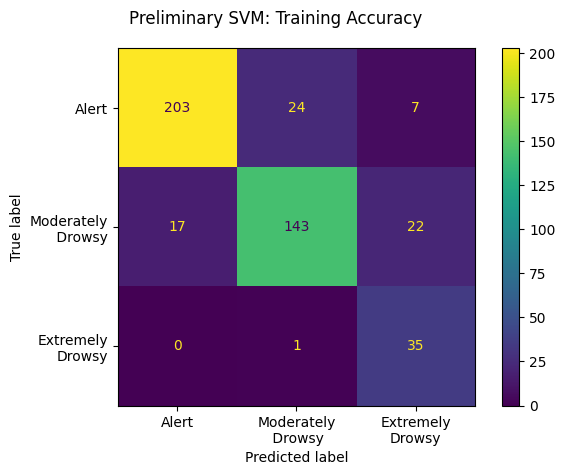

In [47]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [48]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 86.7521%
Accuracy of Moderately Drowsy: 78.5714%
Accuracy of Extremely Drowsy: 97.2222%
----------------------------------------
Micro-average F1: 84.2920%
Weighted-average F1: 84.7743%
Macro-average F1: 80.3805%


{'class_accuracies': array([0.86752137, 0.78571429, 0.97222222]),
 'micro_f1': 0.8429203539823009,
 'weighted_f1': 0.8477431679076839,
 'macro_f1': 0.8038053282987203}

In [49]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_prelim, subject_train, subject_train, EEG_channel_train, X, X_train_scaled, y_train)
display(accuracy_df)

Accuracy of Alert: 86.7521%
Accuracy of Moderately Drowsy: 78.5714%
Accuracy of Extremely Drowsy: 97.2222%
----------------------------------------
Micro-average F1: 84.2920%
Weighted-average F1: 84.7743%
Macro-average F1: 80.3805%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.84292,0.847743,0.803805


* **Preliminary SVM: Testing Accuracy**

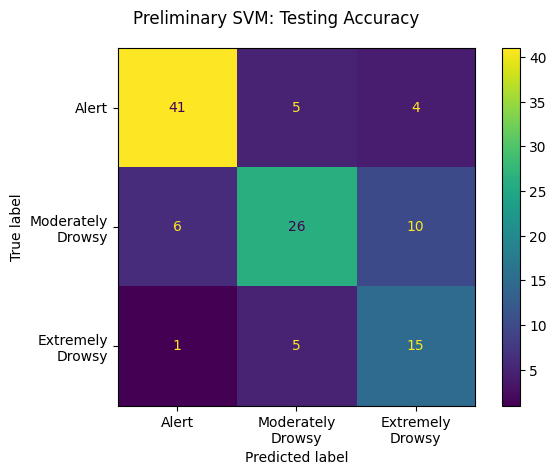

In [50]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=[
                          'Alert',
                          'Moderately\nDrowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [51]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 82.0000%
Accuracy of Moderately Drowsy: 61.9048%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 72.5664%
Weighted-average F1: 72.9529%
Macro-average F1: 70.1134%


{'class_accuracies': array([0.82      , 0.61904762, 0.71428571]),
 'micro_f1': 0.7256637168141593,
 'weighted_f1': 0.7295286256095359,
 'macro_f1': 0.7011337868480726}

In [52]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_prelim, subject_train, subject_train, EEG_channel_train, X, X_test_scaled, y_test)
display(accuracy_df)

Accuracy of Alert: 82.0000%
Accuracy of Moderately Drowsy: 61.9048%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 72.5664%
Weighted-average F1: 72.9529%
Macro-average F1: 70.1134%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134


In [53]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
118,118,2.0,3.0,False
118,118,1.0,1.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [54]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
112,112,2.0,3.0,False
114,114,2.0,3.0,False
114,114,2.0,2.0,True
115,115,2.0,2.0,True


##### **5.2 SVM + Optimized Parameters**

In [55]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed, class_weight='balanced'), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7876


In [56]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

# clf_svm_cv = SVC(random_state=seed, C=10, gamma='scale', kernel='rbf')
clf_svm_cv = SVC(random_state=seed, **optimal_params.best_params_, class_weight='balanced')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)

In [57]:
print(clf_svm_cv.n_features_in_)
print(clf_svm_cv.class_weight_)
print(clf_svm_cv.__class__)
print(str(clf_svm_cv))
print(clf_svm_cv)
clf_svm_cv

10
[0.64387464 0.82783883 4.18518519]
<class 'sklearn.svm._classes.SVC'>
SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)
SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)


SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)

In [58]:
# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_cv.pkl', "wb") as f:
#     pickle.dump(clf_svm_cv, f)

* **Optimized SVM: Training Accuracy**

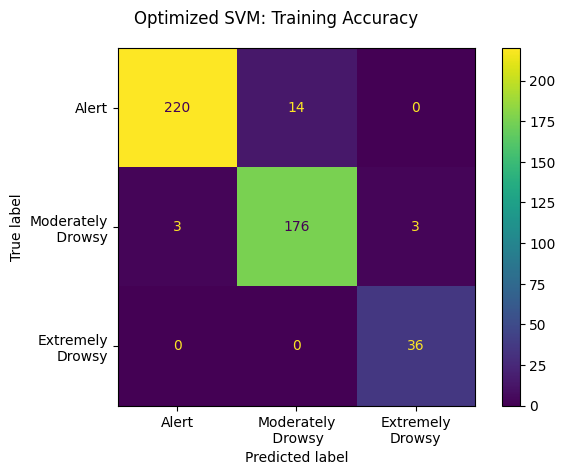

In [59]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [60]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 94.0171%
Accuracy of Moderately Drowsy: 96.7033%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 95.5752%
Weighted-average F1: 95.5908%
Macro-average F1: 95.6346%


{'class_accuracies': array([0.94017094, 0.96703297, 1.        ]),
 'micro_f1': 0.9557522123893806,
 'weighted_f1': 0.9559080941978876,
 'macro_f1': 0.9563458114711026}

In [61]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_cv, subject_train, subject_train, EEG_channel_train, X, X_train_scaled, y_train)
display(accuracy_df)

Accuracy of Alert: 94.0171%
Accuracy of Moderately Drowsy: 96.7033%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 95.5752%
Weighted-average F1: 95.5908%
Macro-average F1: 95.6346%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346


* **Optimized SVM: Testing Accuracy**

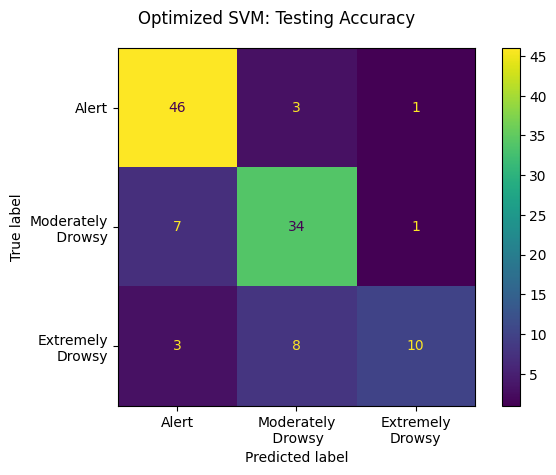

In [62]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [63]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 92.0000%
Accuracy of Moderately Drowsy: 80.9524%
Accuracy of Extremely Drowsy: 47.6190%
----------------------------------------
Micro-average F1: 79.6460%
Weighted-average F1: 78.7178%
Macro-average F1: 75.1865%


{'class_accuracies': array([0.92      , 0.80952381, 0.47619048]),
 'micro_f1': 0.7964601769911505,
 'weighted_f1': 0.7871777464536605,
 'macro_f1': 0.7518647765882639}

In [64]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_cv, subject_train, subject_train, EEG_channel_train, X, X_test_scaled, y_test)
display(accuracy_df)

Accuracy of Alert: 92.0000%
Accuracy of Moderately Drowsy: 80.9524%
Accuracy of Extremely Drowsy: 47.6190%
----------------------------------------
Micro-average F1: 79.6460%
Weighted-average F1: 78.7178%
Macro-average F1: 75.1865%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865


In [65]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
112,112,2.0,2.0,True
114,114,2.0,2.0,True
114,114,2.0,2.0,True
115,115,2.0,2.0,True


##### **5.3 SVM with PCA**

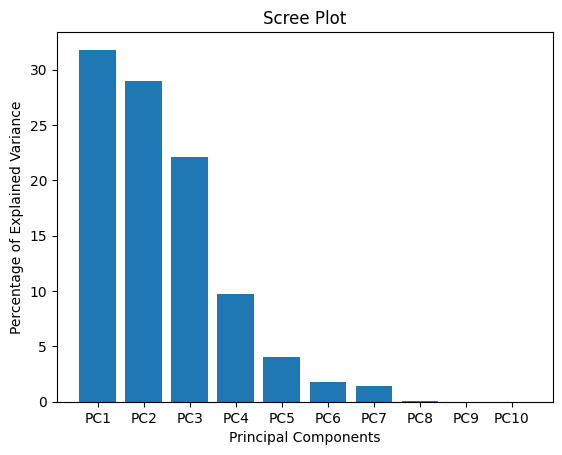

In [66]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [67]:
# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_pca_transformer.pkl', "wb") as f:
#     pickle.dump(pca_transformer, f)

In [68]:
X.columns

Index(['Epoch_minute', 'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'LFHF', 'pLF',
       'pHF'],
      dtype='object')

In [69]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

pHF                -0.464722
pLF                 0.464722
LFHF                0.444998
DeltaRelative_3    -0.373727
AlphaRelative_3     0.288217
BetaRelative_3      0.283075
ThetaRelative_3     0.228593
TA_BRatio_3        -0.117426
Epoch_minute        0.029748
AlphaBetaRatio_3   -0.015582
dtype: float64


In [70]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train = np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          train_pc7_coords,
                                        #   train_pc8_coords
                                          ))

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


pca_scaler = StandardScaler()

pca_train_standardscaled = pca_scaler.fit_transform(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [71]:
pca_scaler_save = pca_scaler.fit(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [72]:

# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_pca_scaler.pkl', "wb") as f:
#     pickle.dump(pca_scaler_save, f)

In [73]:

param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(random_state=seed, class_weight='balanced'), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_standardscaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [74]:
clf_svm_pca = SVC(random_state=seed, **optimal_params.best_params_, class_weight='balanced')
clf_svm_pca.fit(pca_train_standardscaled, y_train)

SVC(C=1000, class_weight='balanced', gamma=0.01, random_state=42)

In [75]:
# with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_pca.pkl', "wb") as f:
#     pickle.dump(clf_svm_pca, f)

In [76]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test = np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                         test_pc7_coords,
                                        #  test_pc8_coords
                                         ))

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                         test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

In [77]:
pca_test_standardscaled = pca_scaler.transform(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                         test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

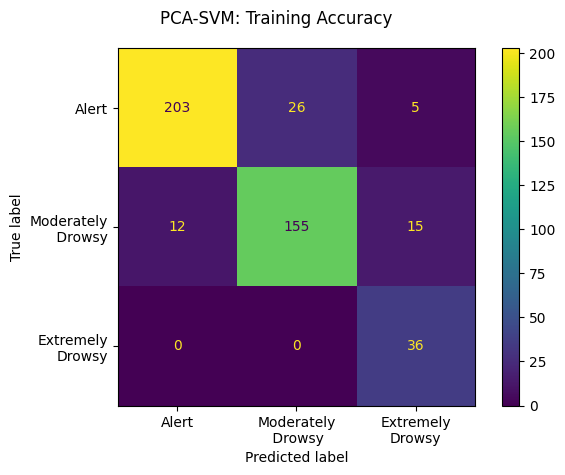

In [78]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_standardscaled, 
                      y_train,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [79]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_standardscaled, y_train)

Accuracy of Alert: 86.7521%
Accuracy of Moderately Drowsy: 85.1648%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 87.1681%
Weighted-average F1: 87.4317%
Macro-average F1: 84.6945%


{'class_accuracies': array([0.86752137, 0.85164835, 1.        ]),
 'micro_f1': 0.8716814159292036,
 'weighted_f1': 0.8743166166683443,
 'macro_f1': 0.84694493728183}

In [80]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_pca, subject_train, subject_train, EEG_channel_train, 'pca', pca_train_standardscaled, y_train)
display(accuracy_df)

Accuracy of Alert: 86.7521%
Accuracy of Moderately Drowsy: 85.1648%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 87.1681%
Weighted-average F1: 87.4317%
Macro-average F1: 84.6945%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945


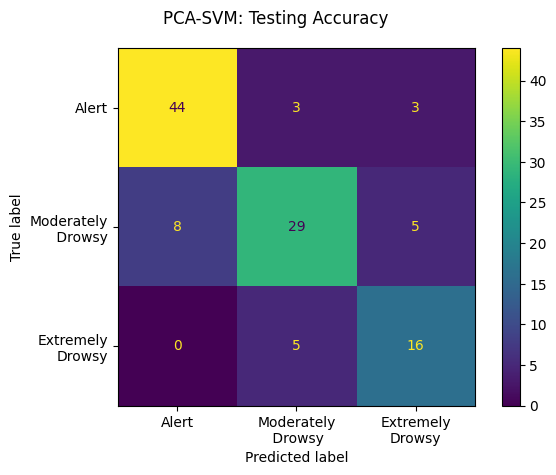

In [81]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_standardscaled, 
                      y_test,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [82]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_standardscaled, y_test)

Accuracy of Alert: 88.0000%
Accuracy of Moderately Drowsy: 69.0476%
Accuracy of Extremely Drowsy: 76.1905%
----------------------------------------
Micro-average F1: 78.7611%
Weighted-average F1: 78.6779%
Macro-average F1: 76.9344%


{'class_accuracies': array([0.88      , 0.69047619, 0.76190476]),
 'micro_f1': 0.7876106194690266,
 'weighted_f1': 0.7867790378165381,
 'macro_f1': 0.7693444747800667}

In [83]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_pca, subject_train, subject_train, EEG_channel_train, 'pca', pca_test_standardscaled, y_test)
display(accuracy_df)

Accuracy of Alert: 88.0000%
Accuracy of Moderately Drowsy: 69.0476%
Accuracy of Extremely Drowsy: 76.1905%
----------------------------------------
Micro-average F1: 78.7611%
Weighted-average F1: 78.6779%
Macro-average F1: 76.9344%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344


In [84]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_standardscaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
118,118,2.0,3.0,False
118,118,1.0,1.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [85]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_standardscaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
112,112,2.0,2.0,True
114,114,2.0,3.0,False
114,114,2.0,3.0,False
115,115,2.0,3.0,False


##### **5.4 SVM SMOTE**

In [86]:
# Count class labels in training data
class_counts_train = y_train.value_counts()

# Count class labels in testing data
class_counts_test = y_test.value_counts()

# Add 'Total' row for training and testing sets
total_train = class_counts_train.sum()
total_test = class_counts_test.sum()
class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# Add 'Total' column for class-wise sum
class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# Print the DataFrame
print(class_counts_df)

           count  count  Total
ORD class                     
1.0          234     50    284
2.0          182     42    224
3.0           36     21     57
Total        452    113    565


In [87]:
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote


,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,56.000000,0.723682,0.173665,0.042553,0.060221,0.706611,3.590417,0.929431,48.171241,51.828759
1,1.500000,0.921980,0.031491,0.018476,0.027485,0.672215,1.817982,1.221629,54.987981,45.012019
2,52.500000,0.927865,0.040561,0.014874,0.016953,0.877349,3.269818,1.629722,61.973166,38.026834
3,1.000000,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,2.337852,70.040617,29.959383
4,25.000000,0.708672,0.113624,0.070392,0.097016,0.725576,1.896770,4.886660,83.012437,16.987563
...,...,...,...,...,...,...,...,...,...,...
697,47.797009,0.859432,0.077391,0.025973,0.035146,0.752606,3.032173,10.557136,91.309531,8.690469
698,50.768300,0.831946,0.076739,0.040262,0.047280,0.817012,2.442157,4.735985,82.371530,17.628470
699,52.729813,0.806061,0.080301,0.049844,0.055793,0.895875,2.336846,5.164149,83.679103,16.320897
700,58.296132,0.869822,0.067312,0.027959,0.034773,0.814016,2.773517,4.258655,80.981144,19.018856


In [88]:
# Count class labels in training data
class_counts_smote = y_train_smote.value_counts()

# Print the DataFrame
print(class_counts_smote)

ORD class
2.0    234
1.0    234
3.0    234
Name: count, dtype: int64


In [89]:
# Data Scaling

# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

smote_scaler = StandardScaler()

X_train_smote_scaled = smote_scaler.fit_transform(X_train_smote)
X_test_scaled = smote_scaler.transform(X_test)

In [90]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed, class_weight='balanced'), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_smote_scaled, y_train_smote)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8732


In [91]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

# clf_svm_cv = SVC(random_state=seed, C=10, gamma='scale', kernel='rbf')
clf_svm_smote = SVC(random_state=seed, **optimal_params.best_params_, class_weight='balanced')
clf_svm_smote.fit(X_train_smote_scaled, y_train_smote)

SVC(C=100, class_weight='balanced', gamma=0.01, random_state=42)

* **SMOTE SVM: Training Accuracy**

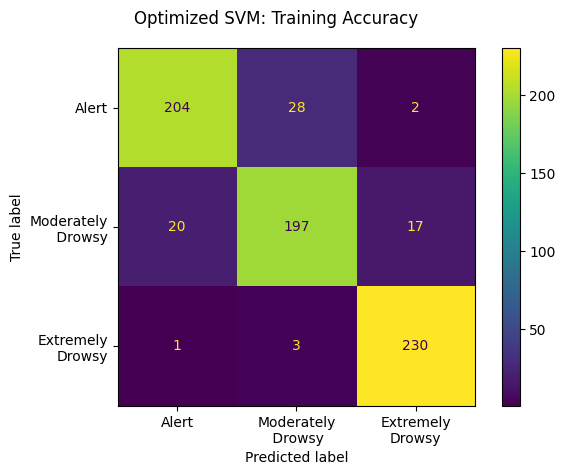

In [92]:
# SMOTE SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_smote, 
                      X_train_smote_scaled, 
                      y_train_smote,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [93]:
# Training Accuracy
classwise_accuracy(clf_svm_smote, X_train_smote_scaled, y_train_smote)

Accuracy of Alert: 87.1795%
Accuracy of Moderately Drowsy: 84.1880%
Accuracy of Extremely Drowsy: 98.2906%
----------------------------------------
Micro-average F1: 89.8860%
Weighted-average F1: 89.8028%
Macro-average F1: 89.8028%


{'class_accuracies': array([0.87179487, 0.84188034, 0.98290598]),
 'micro_f1': 0.8988603988603988,
 'weighted_f1': 0.898027898027898,
 'macro_f1': 0.8980278980278978}

In [94]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_smote, subject_train, subject_train, EEG_channel_train, X, X_train_smote_scaled, y_train_smote)
display(accuracy_df)

Accuracy of Alert: 87.1795%
Accuracy of Moderately Drowsy: 84.1880%
Accuracy of Extremely Drowsy: 98.2906%
----------------------------------------
Micro-average F1: 89.8860%
Weighted-average F1: 89.8028%
Macro-average F1: 89.8028%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344
6,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.871795,0.841880,0.982906,0.898860,0.898028,0.898028


* **SMOTE SVM: Testing Accuracy**

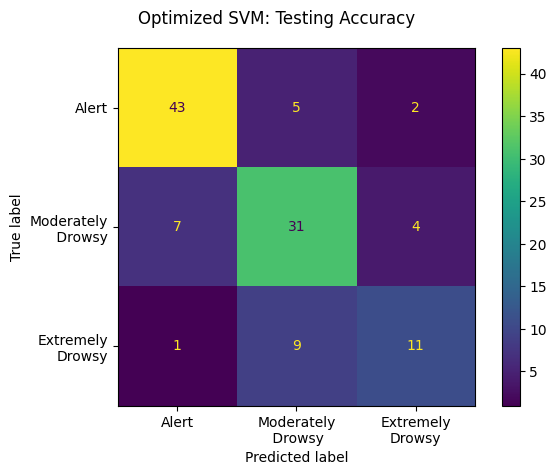

In [95]:
# SMOTE SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_smote, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [96]:
# Testing Accuracy
classwise_accuracy(clf_svm_smote, X_test_scaled, y_test)

Accuracy of Alert: 86.0000%
Accuracy of Moderately Drowsy: 73.8095%
Accuracy of Extremely Drowsy: 52.3810%
----------------------------------------
Micro-average F1: 75.2212%
Weighted-average F1: 74.9232%
Macro-average F1: 71.4359%


{'class_accuracies': array([0.86      , 0.73809524, 0.52380952]),
 'micro_f1': 0.7522123893805309,
 'weighted_f1': 0.749231740224277,
 'macro_f1': 0.7143587316989413}

In [97]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_smote, subject_train, subject_train, EEG_channel_train, X, X_test_scaled, y_test)
display(accuracy_df)

Accuracy of Alert: 86.0000%
Accuracy of Moderately Drowsy: 73.8095%
Accuracy of Extremely Drowsy: 52.3810%
----------------------------------------
Micro-average F1: 75.2212%
Weighted-average F1: 74.9232%
Macro-average F1: 71.4359%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344
6,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.871795,0.841880,0.982906,0.898860,0.898028,0.898028
7,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.860000,0.738095,0.523810,0.752212,0.749232,0.714359


## **6. Model Testing (new cases)**

##### **6.1 Import Data**

In [98]:
# subject_test = str(input('Testing data from subject: '))
print('Testing data: Subject', str(subject_test))

Testing data: Subject 2


In [99]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []
channelList_allcases = []

ECG_features, EEG_features, ord_60min, channelList = load_subject_data(int(subject_test))
EEG_features_allcases.append(EEG_features)
ECG_features_allcases.append(ECG_features)
ord_60min_allcases.append(ord_60min)
channelList_allcases.append(channelList)



In [100]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [101]:
# EEG_channel_list = []

# while True:
#     channel = input('training channel: ')
#     if channel == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             channel_number = int(channel)
#             EEG_channel_list.append(channel_number)
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

# print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


3


In [102]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [103]:
ECG_features_df = ECG_dataframe(0, ECG_features_allcases) # ECG_features_df
    
EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases, channelList_allcases) # EEG_features_df_list
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
EEG_features_df = pd.DataFrame()

for EEG_channel in EEG_channel_list:
    EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from Channel 1
    EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
    EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
    
ord_epoch = ord_dataframe(0, ord_60min_allcases)
    
print(ord_epoch['class name'].value_counts())

combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
# combined_data = combined_dataframe(ECG_features_df, ord_epoch)
combined_data.insert(1, 'Initial_KSS', initial_kss[int(subject_test)-1])


combined_data = combined_data.dropna()

display(combined_data)

class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,6,0.864833,0.071865,0.015796,0.043454,0.363509,2.017333,0.563618,1.322986,0.240017,5.512040,84.643828,15.356172,1.0,Alert
1,1.5,6,0.851991,0.075696,0.018315,0.048819,0.375163,1.925701,0.334687,0.928440,0.802207,1.157357,53.646978,46.353022,1.0,Alert
2,2.0,6,0.881635,0.046852,0.016172,0.049435,0.327126,1.274870,0.369949,1.413259,0.300318,4.705880,82.474220,17.525780,1.0,Alert
3,2.5,6,0.870589,0.044384,0.017434,0.058901,0.295987,1.049528,0.116496,1.710847,0.281581,6.075851,85.867424,14.132576,1.0,Alert
4,3.0,6,0.836520,0.050074,0.021557,0.080031,0.269363,0.895040,0.530470,1.115107,0.430995,2.587285,72.123765,27.876235,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,6,0.910506,0.035776,0.014052,0.037390,0.375815,1.332638,0.147377,1.200727,0.711522,1.687548,62.791365,37.208635,2.0,Moderately Drowsy
115,58.5,6,0.903603,0.042004,0.016325,0.035848,0.455387,1.627116,0.379912,1.084971,0.597031,1.817277,64.504736,35.495264,2.0,Moderately Drowsy
116,59.0,6,0.890681,0.055174,0.015781,0.035700,0.442050,1.987528,0.492459,1.144754,0.437127,2.618813,72.366626,27.633374,2.0,Moderately Drowsy
117,59.5,6,0.878012,0.059321,0.014993,0.043795,0.342343,1.696861,0.459380,1.247259,0.391620,3.184870,76.104396,23.895604,2.0,Moderately Drowsy


##### **6.2 Data Preparation**

In [104]:
combined_data.head()

,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,6,0.864833,0.071865,0.015796,0.043454,0.363509,2.017333,0.563618,1.322986,0.240017,5.512040,84.643828,15.356172,1.0,Alert
1,1.5,6,0.851991,0.075696,0.018315,0.048819,0.375163,1.925701,0.334687,0.928440,0.802207,1.157357,53.646978,46.353022,1.0,Alert
2,2.0,6,0.881635,0.046852,0.016172,0.049435,0.327126,1.274870,0.369949,1.413259,0.300318,4.705880,82.474220,17.525780,1.0,Alert
3,2.5,6,0.870589,0.044384,0.017434,0.058901,0.295987,1.049528,0.116496,1.710847,0.281581,6.075851,85.867424,14.132576,1.0,Alert
4,3.0,6,0.836520,0.050074,0.021557,0.080031,0.269363,0.895040,0.530470,1.115107,0.430995,2.587285,72.123765,27.876235,1.0,Alert


In [105]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data.iloc[:, 0:13].copy()
# X = combined_data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()

excluded_columns = ['Initial_KSS', 'VLF', 'LF', 'HF', 'ORD class', 'class name']
X = combined_data.loc[:, ~combined_data.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(100, 10)


,Epoch_minute,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,0.864833,0.071865,0.015796,0.043454,0.363509,2.017333,5.512040,84.643828,15.356172
1,1.5,0.851991,0.075696,0.018315,0.048819,0.375163,1.925701,1.157357,53.646978,46.353022
2,2.0,0.881635,0.046852,0.016172,0.049435,0.327126,1.274870,4.705880,82.474220,17.525780
3,2.5,0.870589,0.044384,0.017434,0.058901,0.295987,1.049528,6.075851,85.867424,14.132576
4,3.0,0.836520,0.050074,0.021557,0.080031,0.269363,0.895040,2.587285,72.123765,27.876235


In [106]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(100,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [107]:
class_counts = y.value_counts()
print(class_counts)

ORD class
1.0    48
2.0    29
3.0    23
Name: count, dtype: int64


In [108]:
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)
X_scaled = scaler.transform(X)
X_smote_scaled = smote_scaler.transform(X)

##### **6.3 Model Testing**

- SVM CV

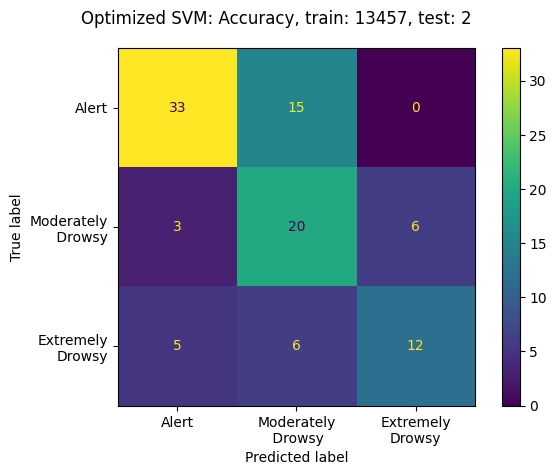

In [109]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_scaled, 
                      y,  
                      display_labels=['Alert',
                                      'Moderately\n Drowsy', 
                                      'Extremely\nDrowsy'
                                      ])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [110]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_scaled, y)

Accuracy of Alert: 68.7500%
Accuracy of Moderately Drowsy: 68.9655%
Accuracy of Extremely Drowsy: 52.1739%
----------------------------------------
Micro-average F1: 65.0000%
Weighted-average F1: 65.6303%
Macro-average F1: 63.2789%


{'class_accuracies': array([0.6875    , 0.68965517, 0.52173913]),
 'micro_f1': 0.65,
 'weighted_f1': 0.6563034882355244,
 'macro_f1': 0.6327891529316577}

In [111]:
accuracy_df = accuracy_record(accuracy_df, clf_svm_cv, subject_train, subject_test, EEG_channel_train, X, X_scaled, y)
display(accuracy_df)

Accuracy of Alert: 68.7500%
Accuracy of Moderately Drowsy: 68.9655%
Accuracy of Extremely Drowsy: 52.1739%
----------------------------------------
Micro-average F1: 65.0000%
Weighted-average F1: 65.6303%
Macro-average F1: 63.2789%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344
6,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.871795,0.841880,0.982906,0.898860,0.898028,0.898028
7,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.860000,0.738095,0.523810,0.752212,0.749232,0.714359
8,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,2,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.687500,0.689655,0.521739,0.650000,0.656303,0.632789


In [112]:
summary = result_summary(clf_svm_cv, X, X_scaled, y)

- SVM SMOTE

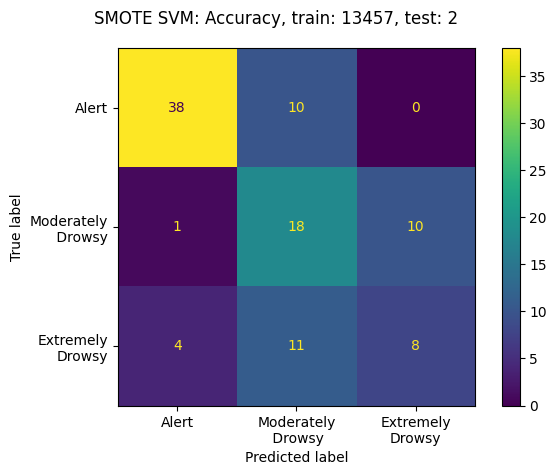

In [113]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_smote, 
                      X_smote_scaled, 
                      y,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("SMOTE SVM: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [114]:
# Training Accuracy
classwise_accuracy(clf_svm_smote, X_smote_scaled, y)

Accuracy of Alert: 79.1667%
Accuracy of Moderately Drowsy: 62.0690%
Accuracy of Extremely Drowsy: 34.7826%
----------------------------------------
Micro-average F1: 64.0000%
Weighted-average F1: 64.4165%
Macro-average F1: 58.4940%


{'class_accuracies': array([0.79166667, 0.62068966, 0.34782609]),
 'micro_f1': 0.64,
 'weighted_f1': 0.6441646302048024,
 'macro_f1': 0.5849401674365806}

In [115]:
accuracy_df = accuracy_record(accuracy_df, clf_svm_smote, subject_train, subject_test, EEG_channel_train, X, X_smote_scaled, y)
display(accuracy_df)

Accuracy of Alert: 79.1667%
Accuracy of Moderately Drowsy: 62.0690%
Accuracy of Extremely Drowsy: 34.7826%
----------------------------------------
Micro-average F1: 64.0000%
Weighted-average F1: 64.4165%
Macro-average F1: 58.4940%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344
6,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.871795,0.841880,0.982906,0.898860,0.898028,0.898028
7,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.860000,0.738095,0.523810,0.752212,0.749232,0.714359
8,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,2,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.687500,0.689655,0.521739,0.650000,0.656303,0.632789
9,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,2,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.791667,0.620690,0.347826,0.640000,0.644165,0.584940


In [116]:
summary = result_summary(clf_svm_smote, X, X_smote_scaled, y)

- SVM PCA

In [117]:
X_pca = pca_transformer.transform(X_scaled)

In [118]:
pc1_coords = X_pca[:, 0]
pc2_coords = X_pca[:, 1]
pc3_coords = X_pca[:, 2]
pc4_coords = X_pca[:, 3]
pc5_coords = X_pca[:, 4]
pc6_coords = X_pca[:, 5]
pc7_coords = X_pca[:, 6]

pca_scaled = scale(np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          pc7_coords,
                                        #   train_pc8_coords
                                          )))

pca = np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          pc7_coords,
                                        #   train_pc8_coords
                                          ))


pca_standardscaled = pca_scaler.transform(np.column_stack((pc1_coords, 
                                         pc2_coords, 
                                         pc3_coords, 
                                         pc4_coords,
                                         pc5_coords, 
                                         pc6_coords, 
                                         pc7_coords,
                                        #  test_pc8_coords
                                         )))

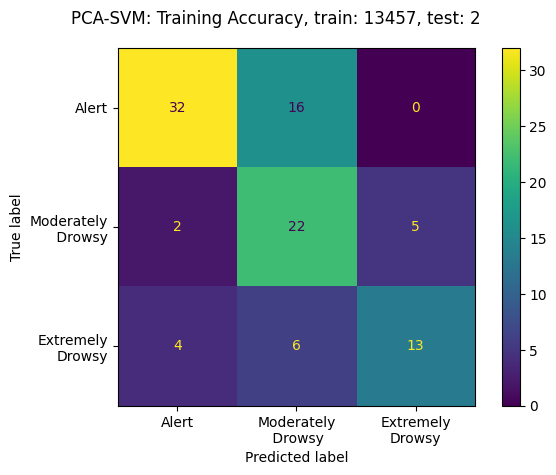

In [119]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_standardscaled, 
                      y,  
                      display_labels=[
                          'Alert',
                          'Moderately\n Drowsy', 
                          'Extremely\nDrowsy'
                          ])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [120]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_standardscaled, y)

Accuracy of Alert: 66.6667%
Accuracy of Moderately Drowsy: 75.8621%
Accuracy of Extremely Drowsy: 56.5217%
----------------------------------------
Micro-average F1: 67.0000%
Weighted-average F1: 67.7857%
Macro-average F1: 66.0357%


{'class_accuracies': array([0.66666667, 0.75862069, 0.56521739]),
 'micro_f1': 0.67,
 'weighted_f1': 0.6778574814101119,
 'macro_f1': 0.6603573713341465}

In [121]:
accuracy_df = accuracy_record(accuracy_df, clf_svm_pca, subject_train, subject_test, EEG_channel_train, 'pca', pca_standardscaled, y)
display(accuracy_df)

Accuracy of Alert: 66.6667%
Accuracy of Moderately Drowsy: 75.8621%
Accuracy of Extremely Drowsy: 56.5217%
----------------------------------------
Micro-average F1: 67.0000%
Weighted-average F1: 67.7857%
Macro-average F1: 66.0357%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.867521,0.785714,0.972222,0.842920,0.847743,0.803805
1,"SVC(class_weight='balanced', random_state=42)",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.820000,0.619048,0.714286,0.725664,0.729529,0.701134
2,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.940171,0.967033,1.000000,0.955752,0.955908,0.956346
3,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.920000,0.809524,0.476190,0.796460,0.787178,0.751865
4,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.867521,0.851648,1.000000,0.871681,0.874317,0.846945
5,"SVC(C=1000, class_weight='balanced', gamma=0.0...",13457,13457,3,PCA,7,0.880000,0.690476,0.761905,0.787611,0.786779,0.769344
6,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.871795,0.841880,0.982906,0.898860,0.898028,0.898028
7,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,13457,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.860000,0.738095,0.523810,0.752212,0.749232,0.714359
8,"SVC(C=100, class_weight='balanced', gamma='aut...",13457,2,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.687500,0.689655,0.521739,0.650000,0.656303,0.632789
9,"SVC(C=100, class_weight='balanced', gamma=0.01...",13457,2,3,"Epoch_minute, DeltaRelative_3, ThetaRelative_3...",10,0.791667,0.620690,0.347826,0.640000,0.644165,0.584940


In [122]:
# Result Summary: SVM-PCA (training)
summary = result_summary(clf_svm_pca, X, pca_standardscaled, y)
display(summary)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,2.0,3.0,False
